In [23]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [24]:
model = YOLO('/home/omar_ben_emad/ID_Card_Data_Extraction/Egyptian_id_data_extractor/runs/detect/train3/weights/best.pt')

In [25]:
img = cv2.imread("/home/omar_ben_emad/ID_Card_Data_Extraction/test/front_image.jpg")
results = model(img)



0: 384x288 1 address, 1 dob, 1 firstName, 1 front_logo, 1 invalid_address, 1 invalid_dob, 1 lastName, 1 nid, 1 photo, 1 serial, 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 288)


# Check Used Device


In [26]:
import torch
def check_device():
    # Check if CUDA is available and return the appropriate device
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return torch.device("cuda")
    else:
        print("CUDA is not available. Using CPU.")
        return torch.device("cpu")

In [27]:
check_device()

CUDA is available. Using GPU.


device(type='cuda')

# Extract BB with its label

In [28]:
# Initialize a dictionary to store labels and bounding boxes
annotations = {}

# Assuming `results` is already obtained from the model
for result in results:
    boxes = result.boxes.xyxy  # Bounding boxes (x1, y1, x2, y2)
    confidences = result.boxes.conf  # Confidence scores
    labels = result.boxes.cls  # Class labels

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        label = labels[i]
        confidence = confidences[i]
        class_name = model.names[int(label)]

        # Store the bounding box in the dictionary without confidence
        if class_name not in annotations:
            annotations[class_name] = []
        annotations[class_name].append({
            'box': (x1, y1, x2, y2),
        })

        # Print the class name and bounding box details
        print(f"Class: {class_name}, Confidence: {confidence:.2f}")
        print(f"Bounding Box: {x1}, {y1}, {x2}, {y2}")

# Print the simplified annotations dictionary
print("\nAnnotations:")
for label, data in annotations.items():
    print(f"Label: {label}")
    for item in data:
        print(f"  Bounding Box: {item['box']}")


Class: photo, Confidence: 0.97
Bounding Box: 8, 76, 63, 146
Class: nid, Confidence: 0.86
Bounding Box: 100, 157, 198, 175
Class: front_logo, Confidence: 0.82
Bounding Box: 95, 67, 172, 93
Class: lastName, Confidence: 0.76
Bounding Box: 95, 108, 189, 121
Class: serial, Confidence: 0.65
Bounding Box: 26, 182, 79, 199
Class: invalid_address, Confidence: 0.59
Bounding Box: 94, 122, 193, 146
Class: invalid_dob, Confidence: 0.46
Bounding Box: 15, 155, 86, 183
Class: address, Confidence: 0.42
Bounding Box: 95, 122, 192, 145
Class: dob, Confidence: 0.39
Bounding Box: 15, 156, 87, 183
Class: firstName, Confidence: 0.25
Bounding Box: 175, 98, 189, 107

Annotations:
Label: photo
  Bounding Box: (8, 76, 63, 146)
Label: nid
  Bounding Box: (100, 157, 198, 175)
Label: front_logo
  Bounding Box: (95, 67, 172, 93)
Label: lastName
  Bounding Box: (95, 108, 189, 121)
Label: serial
  Bounding Box: (26, 182, 79, 199)
Label: invalid_address
  Bounding Box: (94, 122, 193, 146)
Label: invalid_dob
  Bounding 

In [29]:
annotations

{'photo': [{'box': (8, 76, 63, 146)}],
 'nid': [{'box': (100, 157, 198, 175)}],
 'front_logo': [{'box': (95, 67, 172, 93)}],
 'lastName': [{'box': (95, 108, 189, 121)}],
 'serial': [{'box': (26, 182, 79, 199)}],
 'invalid_address': [{'box': (94, 122, 193, 146)}],
 'invalid_dob': [{'box': (15, 155, 86, 183)}],
 'address': [{'box': (95, 122, 192, 145)}],
 'dob': [{'box': (15, 156, 87, 183)}],
 'firstName': [{'box': (175, 98, 189, 107)}]}

# Operations Over Data Exrtacted

# 1. Face

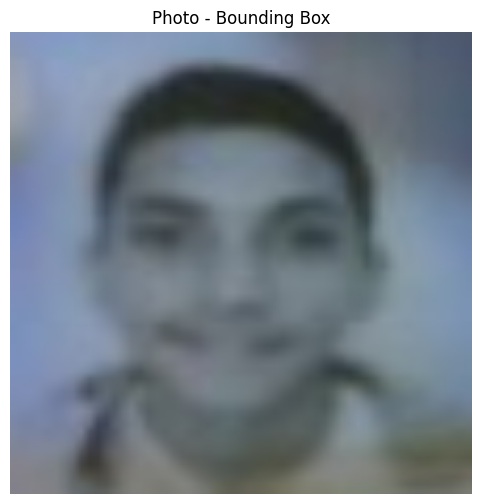

In [30]:

# Process only the label 'photo'
if 'photo' in annotations:
    for item in annotations['photo']:
        x1, y1, x2, y2 = item['box']
        # Extract the region from the image
        roi = img[y1:y2, x1:x2]

        # Optionally, resize or wrap the region
        desired_size = (300, 300)  # Example size
        wrapped_roi = cv2.resize(roi, desired_size, interpolation=cv2.INTER_LINEAR)

        # Display the extracted and processed region
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(wrapped_roi, cv2.COLOR_BGR2RGB))
        plt.title(f'Photo - Bounding Box')
        plt.axis('off')  # Hide the axis
        plt.show()



# 2. First and Last Name

In [31]:
import pytesseract
from pytesseract import Output


In [ ]:

# Process the labels 'firstName' and 'lastName'
for label in ['firstName', 'lastName']:
    if label in annotations:
        for item in annotations[label]:
            x1, y1, x2, y2 = item['box']
            # Extract the region from the image
            roi = img[y1:y2, x1:x2]

            # Preprocess the region to improve OCR accuracy
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Resize or wrap the region if necessary
            if label == 'firstName':
                desired_size = (2480, 1680)  # Size for firstName
                wrapped_roi = cv2.resize(binary_roi, desired_size, interpolation=cv2.INTER_LINEAR)
                
                # Perform OCR with specific config for firstName
                config = '--oem 1 --psm 7'
                text = pytesseract.image_to_string(wrapped_roi, lang='ara', config=config)
            else:
                desired_size = (1240, 300)  # Size for lastName
                wrapped_roi = cv2.resize(binary_roi, desired_size, interpolation=cv2.INTER_LINEAR)
                
                # Perform OCR without specific config for lastName
                text = pytesseract.image_to_string(wrapped_roi, lang='ara')

            # Display the extracted and processed region
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f'{label} - Bounding Box')
            plt.axis('off')  # Hide the axis
            plt.show()

            print(f'{label} - OCR Text: {text.strip()}')


In [ ]:
# Extract information from the results
for result in results:
    boxes = result.boxes.xyxy  # Bounding boxes (x1, y1, x2, y2)
    confidences = result.boxes.conf  # Confidence scores
    labels = result.boxes.cls  # Class labels

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        confidence = confidences[i]
        label = labels[i]

        # Convert label index to the actual class name if needed
        class_name = model.names[int(label)]

        print(f"Class: {class_name}, Confidence: {confidence:.2f}")
        print(f"Bounding Box: {x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}")


# 3. Address

(23, 97, 3)


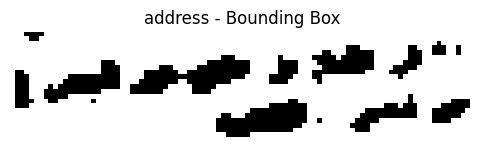

address\ - OCR Text: اللا
ال


In [34]:

# Loop through each label and its corresponding bounding box
for label in ['address']:
    if label in annotations:
        for item in annotations[label]:
            x1, y1, x2, y2 = item['box']
            # Extract the region from the image
            roi = img[y1:y2, x1:x2]
            print(np.shape(roi))

            # Preprocess the region to improve OCR accuracy
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # No resizing; use the original ROI
            wrapped_roi = binary_roi  # Keep the ROI as is

            # Display the extracted and processed region
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(wrapped_roi, cv2.COLOR_GRAY2RGB))  # Adjusted for grayscale image
            plt.title(f'{label} - Bounding Box')
            plt.axis('off')  # Hide the axis
            plt.show()

            # Perform OCR with specific config for the address (general text recognition)
            custom_config_text = r'--oem 3 --psm 6 -l ara'
            text = pytesseract.image_to_string(wrapped_roi, lang='ara', config=custom_config_text)
            print(f'{label}\ - OCR Text: {text.strip()}')



# 4. National ID

(18, 98, 3)


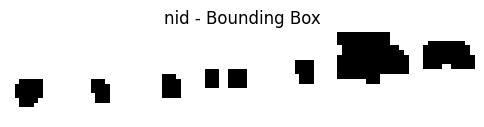

nid - OCR Numbers: 00000000


In [35]:
# Arabic to English numeral mapping
arabic_to_english = {
    '٠': '0',
    '١': '1',
    '٢': '2',
    '٣': '3',
    '٤': '4',
    '٥': '5',
    '٦': '6',
    '٧': '7',
    '٨': '8',
    '٩': '9'
}

for label in ['nid']:
    if label in annotations:
        for item in annotations[label]:
            x1, y1, x2, y2 = item['box']
            roi = img[y1:y2, x1:x2]
            print(np.shape(roi))

            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            blurred_roi = cv2.GaussianBlur(gray_roi, (3, 3), 0)
            _, binary_roi = cv2.threshold(blurred_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            kernel = np.ones((3, 3), np.uint8)
            binary_roi = cv2.dilate(binary_roi, kernel, iterations=1)
            binary_roi = cv2.erode(binary_roi, kernel, iterations=1)

            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(binary_roi, cv2.COLOR_GRAY2RGB))
            plt.title(f'{label} - Bounding Box')
            plt.axis('off')
            plt.show()

            custom_config_numbers = r'--oem 3 --psm 7 -c tessedit_char_whitelist="٠١٢٣٤٥٦٧٨٩"'
            numbers = pytesseract.image_to_string(binary_roi, lang='ara_number_id', config=custom_config_numbers)
            
            # Clean and rearrange the OCR result
            clean_numbers = numbers.replace(" ", "").strip()
            
            # Convert Arabic numbers to English
            english_numbers = ''.join(arabic_to_english.get(c, c) for c in clean_numbers)
            
            # Check if the length of english_numbers is correct before rearranging
            if len(english_numbers) >= 14:  # Adjust based on the expected length
                # Reformat according to the specific segments needed
                formatted_numbers = f'{english_numbers[0:3]} {english_numbers[3:5]} {english_numbers[5:7]} {english_numbers[7:9]} {english_numbers[9:12]} {english_numbers[12:14]}'
            else:
                formatted_numbers = english_numbers  # Just return the cleaned number if it's too short
            
            # Store the final formatted number in numbers_english
            numbers_english = formatted_numbers
            
            print(f'{label} - OCR Numbers: {numbers_english}')


# 4.1 Know Gouvernate from National ID


In [ ]:
print(numbers_english)
print(numbers_english[11])

In [ ]:

governorates = {'01': 'Cairo',
                '02': 'Alexandria',
                '03': 'Port Said',
                '04': 'Suez',
                '11': 'Damietta',
                '12': 'Dakahlia',
                '13': 'Ash Sharqia',
                '14': 'Kaliobeya',
                '15': 'Kafr El - Sheikh',
                '16': 'Gharbia',
                '17': 'Monoufia',
                '18': 'El Beheira',
                '19': 'Ismailia',
                '21': 'Giza',
                '22': 'Beni Suef',
                '23': 'Fayoum',
                '24': 'El Menia',
                '25': 'Assiut',
                '26': 'Sohag',
                '27': 'Qena',
                '28': 'Aswan',
                '29': 'Luxor',
                '31': 'Red Sea',
                '32': 'New Valley',
                '33': 'Matrouh',
                '34': 'North Sinai',
                '35': 'South Sinai',
                '88': 'Foreign'}

fake_national_id_message = 'This ID Not Valid'


# Extracting the governorate code (characters at index 6 and 7)
governorate_code = numbers_english[10:12]

# Checking if the governorate code is valid
if governorate_code in governorates:
    print(f'The governorate is: {governorates[governorate_code]}')
else:
    print(fake_national_id_message)


# 4.2 Know Birth Date from National ID


## Year

In [ ]:
first_digit = numbers_english[0]
if first_digit == '2':
    century = '19'
elif first_digit == '3':
    century = '20'
elif first_digit == '1':
    century = '18'
elif first_digit == '4':
    century = '21'

# Extract the second and third digits (year)
year_part = numbers_english[1:3]
birth_year = century + year_part

# Print the birth year
print(f'Birth Year: {birth_year}')

## Month

In [ ]:
month_part = year_part = numbers_english[4:6]
print(month_part)

## Day

In [ ]:
day_part = year_part = numbers_english[6:9]
print(day_part)

In [ ]:
# Combine to form the full birthdate
birth_date = f'{day_part}/{month_part}/{birth_year}'
# Print the birth date
print(f'Birth Date: {birth_date}')

# "The Back of The ID"

In [ ]:
img_back = cv2.imread("fdd.jpg")
back_results = model(img_back)


In [ ]:
back_results

In [ ]:

# Define colors and styles
box_color = (0, 255, 255)  # Yellow color in BGR
text_color = (255, 255, 255)  # White color in BGR
text_background_color = (0, 0, 0)  # Black background in BGR
font = cv2.FONT_HERSHEY_COMPLEX
font_scale = 0.8
font_thickness = 2
box_thickness = 3

# Initialize a dictionary to store labels and bounding boxes
back_annotations = {}

# Assuming `results` is already obtained from the model
for result in back_results:
    boxes = result.boxes.xyxy  # Bounding boxes (x1, y1, x2, y2)
    confidences = result.boxes.conf  # Confidence scores
    labels = result.boxes.cls  # Class labels

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        label = labels[i]
        confidence = confidences[i]
        class_name = model.names[int(label)]

        # Store the bounding box in the dictionary without confidence
        if class_name not in back_annotations:
            back_annotations[class_name] = []
        back_annotations[class_name].append({
            'box': (x1, y1, x2, y2),
        })

        # Print the class name and bounding box details
        print(f"Class: {class_name}, Confidence: {confidence:.2f}")
        print(f"Bounding Box: {x1}, {y1}, {x2}, {y2}")

        # Draw the bounding box with a thicker line and color
        cv2.rectangle(img_back, (x1, y1), (x2, y2), box_color, box_thickness)

# Convert BGR image (OpenCV default) to RGB for matplotlib
img_rgb = cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')  # Hide the axis
plt.show()

# Print the simplified annotations dictionary
print("back_annotations:")
for label, data in back_annotations.items():
    print(f"Label: {label}")
    for item in data:
        print(f"  Bounding Box: {item['box']}")

In [ ]:
back_annotations

# 5. Get religion , gender and marital status

In [ ]:

# Loop through each label and its corresponding bounding box
for label in ['demo']:
    if label in back_annotations:
        for item in back_annotations[label]:
            x1, y1, x2, y2 = item['box']
            # Extract the region from the image
            roi = img_back[y1:y2, x1:x2]
            print(np.shape(roi))

            # Preprocess the region to improve OCR accuracy
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            dilated_roi = cv2.dilate(binary_roi, np.ones((2,2), np.uint8), iterations=1)  # Thicken the text

            # Resize the ROI to improve OCR accuracy
            scale_factor = 2  # You can adjust the scale factor as needed
            resized_roi = cv2.resize(dilated_roi, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

            # Display the extracted and processed region
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(resized_roi, cv2.COLOR_GRAY2RGB))  # Adjusted for grayscale image
            plt.title(f'{label} - Resized and Processed Bounding Box')
            plt.axis('off')  # Hide the axis
            plt.show()

            # Perform OCR with specific config for the address (general text recognition)
            custom_config_text = r'--oem 3 --psm 6 -l ara'
            text = pytesseract.image_to_string(resized_roi, lang='ara', config=custom_config_text)
            print(f'{label} - Corrected OCR Text: {text}')

            # Split the text into individual words
            words = text.split()  # Split on whitespace
            print(f'{label} - OCR Words: {words}')


In [ ]:
print("gender is  " + words[0])
print("religion is  " + words[1])
print("marital status is  " + words[2])

# 6. Job Info Extraction

In [ ]:
# Loop through each label and its corresponding bounding box
for label in ['job']:
    if label in back_annotations:
        for item in back_annotations[label]:
            x1, y1, x2, y2 = item['box']
            
            # Extract the region from the image
            roi = img_back[y1:y2, x1:x2]
            print(np.shape(roi))

            # Convert ROI to grayscale
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            
            # Display the extracted and processed region
            plt.figure(figsize=(6, 6))
            plt.imshow(roi)
            plt.title(f'{label} - Extracted Bounding Box')
            plt.axis('off')  # Hide the axis
            plt.show()

            # Perform OCR with specific config for Arabic text
            custom_config_text = r'--oem 3 --psm 6 -l ara'
            text = pytesseract.image_to_string(roi, config=custom_config_text)
            print(f'{label} - OCR Text: {text.strip()}')